# Keyrir Strætó of hratt?: Samanburður keyrsluhraðagagna frá Strætó API-inu við hámarkshraðagögn

_**Árni Dagur Guðmundsson**: arni@dagur.eu | Menntaskólinn við Hamrahlíð_

## Inngangur:

### Open Street Map

### API
Falið í kóða heimasíðu Strætó má finna API (forritaskil) sem geyma ýmsar upplýsingar um staka strætisvagna í rauntíma. Strætó appið notar þetta API meðal annars til að sýna staðsetningu strætisvagna á korti. Ég bjó til einfaldan Python pakka sem kallar á API-ið og spýtir út niðurstöðunum í JSON. Hér fyrir neðan sést niðurstaða einfalds kalls:

In [1]:
from straeto import api
api.getBusPositionsFor(["1", "55"])[0]

{'deviceNumber': 112,
 'gpsFix': 2,
 'gpsTime': '180519121259',
 'heading': 196.02,
 'lastStop': 13001525,
 'lat': 64.0817166666667,
 'lon': -21.948,
 'nextStop': 14001526,
 'pingCode': 6,
 'route': '1-C',
 'routeNumber': '1',
 'speed': 26.06}

Eins og sést býður API-ið upp á breiddargráðu (_lat_), og lengdargráðu (_lon_). Því er til dæmis hægt að birta staðsetningu allra strætisvagna landsins á kort líkt og svo:

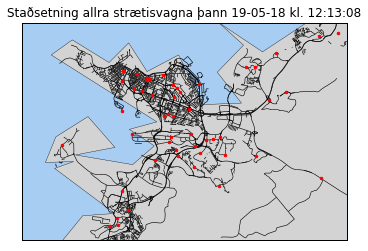

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import warnings; warnings.filterwarnings('ignore')
from datetime import datetime

from straeto import straeto

map = straeto.getMap()

map.readshapefile('osm-data/output/extracted_roads', 'roads',
                  drawbounds=True, color='black', linewidth=0.6)

for bus in api.getAllBusPositions():
    X, Y = map(bus['lon'], bus['lat'])
    map.plot(X, Y, 'ro', markersize=2.5)

plt.title('Staðsetning allra strætisvagna þann {}'.format(datetime.now().strftime('%d-%m-%y kl. %H:%M:%S')))
plt.show()

Hraðinn er einnig til staðar en ekki vitum við þó hvaða mælieining notuð er til þess að mæla hann.

$k\cdot v_{api} = v \Rightarrow k = \frac{v}{v_{api}}$

In [3]:
from straeto import straeto
bdict, p_bdict = straeto.getConsecutiveBuses(ratio=0.5)

print(len(bdict),len(p_bdict))

36 36


In [4]:
from geopy.distance import geodesic
from datetime import datetime as dt
G = []
B = []
Ks = []
for key in bdict:
    bus = bdict[key]; p_bus = p_bdict[key]
    t_1 = dt.strptime(bus['gpsTime'],"%y%m%d%H%M%S"); t_2 = dt.strptime(p_bus['gpsTime'],"%y%m%d%H%M%S")
    delta_t = (t_1-t_2).total_seconds()
    delta_s = geodesic((bus['lat'], bus['lon']), (p_bus['lat'], p_bus['lon'])).km

    kmh = (delta_s/delta_t)*3600
    avg_speed = (1/2)*(bus['speed']+p_bus['speed'])

    k = kmh/avg_speed
    Ks.append(k)
    dic = {
        'speed_0': p_bus['speed'],
        'speed_1': bus['speed'],
        'delta_s': delta_s,
        'delta_t': delta_t,
        'kmh': kmh,
        'avg_speed': avg_speed,
        'route': bus['route'],
        'k': k
    }
    if 1.7 < k < 1.9:
        G.append(dic)
    else:
        B.append(dic)

print('Good:')
for i in G:
    print('{} | k = {} / {} = {} | {} --> {}'.format(
        i['route'], round(i['kmh'], 2), round(i['avg_speed'], 2), round(i['k'], 2), i['speed_0'], i['speed_1']
    ))
print('Bad:')
for i in B:
    print('{} | k = {} / {} = {} | {} --> {}'.format(
        i['route'], round(i['kmh'], 2), round(i['avg_speed'], 2), round(i['k'], 2), i['speed_0'], i['speed_1']
    ))
avg_k = sum(Ks)/len(Ks)
print(avg_k)


Good:
51-E | k = 72.23 / 38.91 = 1.86 | 37.77 --> 40.04
35-A | k = 10.23 / 5.9 = 1.73 | 9.78 --> 2.03
13-B | k = 31.02 / 16.76 = 1.85 | 18.35 --> 15.16
23-A | k = 50.2 / 27.34 = 1.84 | 25.16 --> 29.51
4-A | k = 26.39 / 14.45 = 1.83 | 19.65 --> 9.26
6-A | k = 46.28 / 26.04 = 1.78 | 24.16 --> 27.91
14-C | k = 28.7 / 15.14 = 1.9 | 11.14 --> 19.14
12-B | k = 47.41 / 25.8 = 1.84 | 24.91 --> 26.68
51-C | k = 67.64 / 35.68 = 1.9 | 36.16 --> 35.2
Bad:
43-B | k = 20.91 / 13.0 = 1.61 | 12.79 --> 13.22
11-B | k = 24.07 / 9.44 = 2.55 | 16.58 --> 2.3
7-A | k = 29.2 / 14.39 = 2.03 | 19.6 --> 9.18
12-A | k = 27.75 / 11.52 = 2.41 | 6.98 --> 16.06
7-B | k = 31.89 / 15.52 = 2.06 | 18.54 --> 12.49
21-B | k = 26.6 / 13.07 = 2.03 | 15.5 --> 10.65
36-A | k = 26.03 / 17.27 = 1.51 | 21.08 --> 13.45
57-A | k = 63.25 / 33.2 = 1.91 | 30.06 --> 36.33
1-C | k = 46.63 / 24.42 = 1.91 | 26.06 --> 22.78
43-A | k = 20.77 / 14.84 = 1.4 | 14.57 --> 15.1
1-A | k = 26.51 / 16.95 = 1.56 | 16.97 --> 16.92
1-B | k = 42.9 / 20

## Undirbúningur gagna:

```
ALTER TABLE buses ADD COLUMN geom Geometry(Point, 4326);
```
svo:
```
UPDATE buses SET geom=ST_SetSrid(ST_MakePoint(lon, lat), 4326);
```

```
SELECT r.maxspeed FROM roads r, buses b WHERE ST_DWithin(b.geom, r.geom, 8) ORDER BY ST_Distance(r.geom, b.geom);
```

In [5]:
!psql straeto -c "\dt"

            List of relations
 Schema |      Name       | Type  | Owner 
--------+-----------------+-------+-------
 public | roads           | table | arni
 public | spatial_ref_sys | table | arni
(2 rows)

